# Using Queues

During actual games, players will have a predetermined set of purchases they intend to make and also a predetermined way of eco'ing that they've flowcharted out. The simulator can model these sorts of actions with the *buy queue* and the *eco queue*. In this tutorial, I'll show how to simulate flowcharts using these two features. Like last time, let's import the `b2sim` module:

In [3]:
import b2sim.engine as b2
import b2sim.analysis as dd

## Round Lengths

In BTD Battles 2, the length of a round depends on how fast either player pops or leaks all of the natural bloons on their side of the screen. There are *four* timers that govern round length:

1. The *single* anti-stall timer (4 seconds) - This timer triggers when *one* player has popped all of the natural bloons on their side.
2. The *double* anti-stall timer (2 seconds) - This timer triggers when *both* players have popped all of the natural bloons on their side.
3. The minimum round length timer (5.5 seconds) - This timer triggers when the last natural bloon of the round spawns.
4. The maximum round length timer (8.5 + `round number` seconds) - This timer also triggers when the last natural bloon of the round spawns.

Rounds end once the minimum round length timer is completely exhausted *and* any of the other three timers completely run through. In ideal perfect anti-stall, rounds end 5.5 seconds after the last natural spawns. In ideal stall, rounds only end once the maxmimum round length timer is completely exhausted. In practice, however, achieving theoretical full stall beyond the first few rounds of the game is virtually impossible.

## The Rounds class

The rounds class is the simulator's tool for automatically and quickly generating round lengths true to actual games. Accurate round lengths is the key to accurate simulation, and the rounds class has four different modes for generating round lengths:
1. **Stall Factor** - Generates round lengths based on a perceived level of stall ranging on $0$ (full anti-stall) to $1$ (full stall). The user can specify different stall factors for different rounds if desired. The round lengths are computed based on data collected by spoonoil and ninjayas in October 2022 --- or rather, a modified version of such which accounts for NK's recent changes to round length rules.
2. **Stall Times** - The user specifies the amount of time each round takes after the last natural bloon spawns to end.
3. **Manual** - The user manually inputs the round lengths they want to work with.
4. **Theoretical Stall Factor** - Like stall factor, except round lengths are computed using the minimum and maximum length timers. That is, a stall factor of $1$ assumes that the maximum round length timer is exhausted and the next round might start without every natural having been popped beforehand.

I recommend the stall factor mode if you need to quickly generate reasonably accurate simulations. The stall times mode may be a bit more finicky but can generate more precise results. The greatest precision (but perhaps most amount of tedium) is afforded by using the manual mode. To initialize the rounds class, we can use a structure as follows:

In [4]:
rounds = b2.Rounds(info = [(1,9.5), (2,7), (10,5.75)], mode = 'Stall Times')

In the stall times mode, each tuple $(r,t)$ informs the simulator on round $r$ that the round is stalled by $t$ seconds. When a stall time is not explicitly specified for a given round, the simulator searches backwards until it finds a round whose stall time *has* been specified and uses that value. The above initiliazes the `Rounds` class assigning stall times to each round as follows:

| Rounds | Stall Times |
|-------|----------|
| 1   | 9.5 |
| 2 - 9    | 7 |
| 10 - 50    | 5.75 |


## The Eco Queue

The eco queue is a list which tells us what eco sends to use and at what points of the game to use them. For example, a typical midgame eco flowchart *might* look something like:

| Round | Eco Send |
|-------|----------|
| 10    | Grouped Reds |
| 12    | Spaced Rainbows  |
| 13    | None |
| 14    | Grouped Blacks |

Implementing something like this is relatively easy in the eco sim. All we need to do is write something like...

In [5]:
eco_queue = [
    b2.ecoSend(time=rounds.getTimeFromRound(10), send_name='Grouped Reds'),
    b2.ecoSend(time=rounds.getTimeFromRound(12), send_name='Spaced Rainbows'),
    b2.ecoSend(time=rounds.getTimeFromRound(13), send_name='Zero'),
    b2.ecoSend(time=rounds.getTimeFromRound(14), send_name='Grouped Blacks')
]

## The Buy Queue

The buy queue is a list of lists. Each item in the buy queue prescribes a list of actions the player wishes to take. Every time the player receives a payment in the simulator, the simulator will check whether there is enough cash to execute the next item in the buy queue. In most cases (such as this example), items in the buy queue will just be lists with one action, but for cases like selling farms into better farm upgrades or more defense, it is useful to have an item in the buy queue which prescribes multiple actions to be taken simultaneously. For a full list of actions and their arguments, the player should refer to `actions.py`.

A typical list of buy queue actions for rounds 10 - 14 for dartling alch eco could look something like:

In [6]:
buy_queue = [
    [b2.buyDefense(5600 - 0.7*2500, message="sell into hrp")], #Sell into HRP
    [b2.buyDefense(2550,min_buy_time=rounds.getTimeFromRound(14), message="buy l2g")] #Buy Lead to Gold
]

## Simulation Example

We consider dartling alch eco play from rounds 10 to 15 with the given rounds object and eco and buy queues given above:

,Time,Type,Message
0,231.5,Eco,Change eco to Grouped Reds
1,240.0,Buy,sell into hrp
2,242.2,Round,Round 11 start
3,256.0,Round,Round 12 start
4,256.0,Eco,Change eco to Spaced Rainbows
5,272.8,Round,Round 13 start
6,272.8,Eco,Change eco to Zero
7,291.0,Round,Round 14 start
8,291.0,Buy,buy l2g
9,291.0,Eco,Change eco to Grouped Blacks


The current cash and eco are (24.0,955.0)


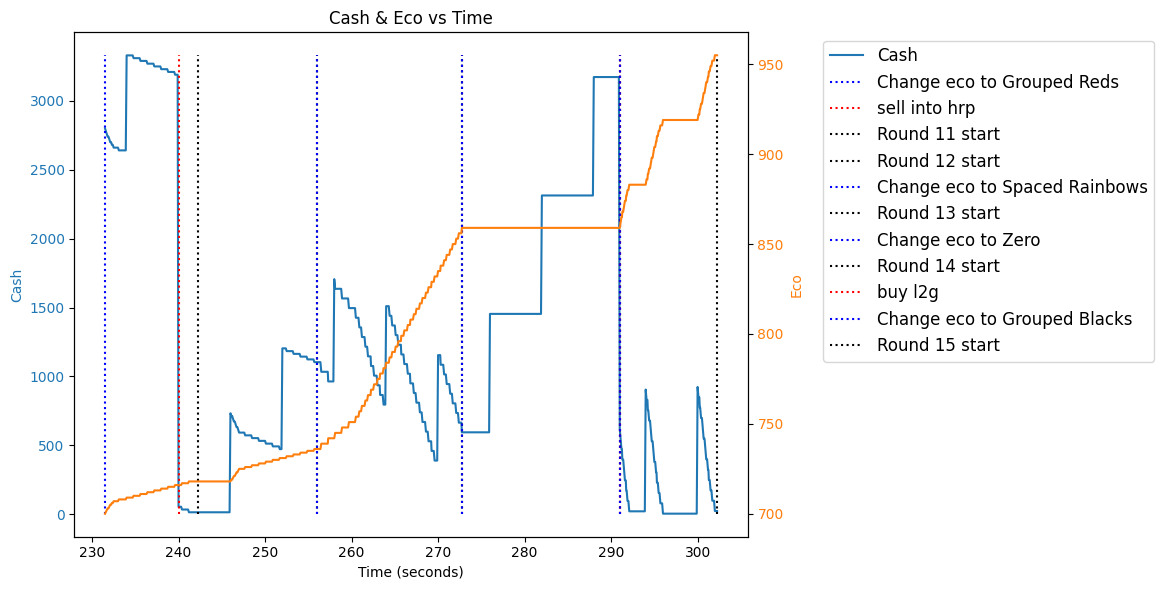

In [7]:
initial_state_game = {
    'Cash': 2800,
    'Eco': 700,
    'Rounds': rounds,
    'Game Round': 10,
    'Buy Queue': buy_queue,
    'Eco Queue': eco_queue
}

game_state = b2.GameState(initial_state_game)
game_state.fastForward(target_round = 15)
dd.viewHistory(game_state)
b2.writeLog(game_state.logs, filename = 'using_queues')
print("The current cash and eco are (%s,%s)"%(game_state.cash, game_state.eco))

## More about Minimum Buy Time + Buffer

Most buy queue actions support an argument `min_buy_time`, which tells the simulator to wait until the specified time to attempt the action. This is most useful for timing complex farm flowcharts (like selling into Monkey Wall Street just before the end of R24) but is a useful QOL feature even for mapping out general flowcharts.

Most buy queue actions *also* support an argument called `buffer`. The buffer argument for a given action waits until you have the necessary cash for that action *plus* the specified buffer amount before actually carrying out that action. This is useful for scenarios where you are making purchases while eco'ing and wish to make your purchases only when they do not interfere with your eco.